# **Maestría en Inteligencia Artificial Aplicada (MNA)**
## **Procesamiento de Lenguaje Natural (NLP)**
### Prof. Luis Eduardo Falcón Morales
### **Semanas 6 y 7 - Ejercicios Complementarios**
### Modelado de Temas: LSI / LDA.

### **NOTA: Estos ejercicios son simplemente para que repases los conceptos de esta semana.**
### **No es una tarea o actividad que debas entregar.**

# Parte - 1:

## Indexación Semántica Latente - LSI - Latent Semantic Indexing

In [2]:
# Actualicemos primero algunas de las librerías que usaremos:

!pip install scipy --upgrade --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.4 MB/s eta 0:00:00


In [3]:
!pip install gensim --upgrade --user

In [4]:
!pip install numpy --upgrade --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 28.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Supongamos que iniciamos con los documentos ya tokenizados, después de la limpieza y procesado de los documentos de la manera usual en la que hemos venido procediendo:

In [ ]:
docs = [['manzana','manzana','pera', 'pera','uva','uva','melon','sandia'],
        ['manzana','manzana','manzana','uva','uva','melon','melon','cocina',],
        ['estufa','estufa','estufa','olla','olla','olla','horno','horno'],
        ['horno','horno','horno','cuchara','cuchara','olla','uva','uva'],
        ['horno','manzana','pera','pera','olla','olla'],
        ['libro','libro','autor','novela','novela','ficcion']
        ]

docs

[['manzana', 'manzana', 'pera', 'pera', 'uva', 'uva', 'melon', 'sandia'],
 ['manzana', 'manzana', 'manzana', 'uva', 'uva', 'melon', 'melon', 'cocina'],
 ['estufa', 'estufa', 'estufa', 'olla', 'olla', 'olla', 'horno', 'horno'],
 ['horno', 'horno', 'horno', 'cuchara', 'cuchara', 'olla', 'uva', 'uva'],
 ['horno', 'manzana', 'pera', 'pera', 'olla', 'olla'],
 ['libro', 'libro', 'autor', 'novela', 'novela', 'ficcion']]

In [ ]:
# Conjuntamos los documentos de nuevo en una lista de strings,
# que viene a ser nuestra document-term-matrix, DTM:

ddf = []

for doc in docs:
    tmp = ' '.join(doc)
    ddf.append(tmp)

ddf

['manzana manzana pera pera uva uva melon sandia',
 'manzana manzana manzana uva uva melon melon cocina',
 'estufa estufa estufa olla olla olla horno horno',
 'horno horno horno cuchara cuchara olla uva uva',
 'horno manzana pera pera olla olla',
 'libro libro autor novela novela ficcion']

In [ ]:
ddf[0]

'manzana manzana pera pera uva uva melon sandia'

### Obtengamos la matriz Tf-idf a partir de los documentos ya procesados:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
tfidf = TfidfVectorizer(lowercase=True, # puedes incluir algunas transformaciones, en caso de que no las hayas llevado a cabo previamente.
                        max_df=1.0,  # (float o int) ignora las palabras con frecuencia mayor a max_df
                        min_df=1     # ignora las palabras con frecuencia menor a min_df
                       )

tfidf_sparse = tfidf.fit_transform(ddf)     # csr_matrix de la DTM

In [ ]:
# Este paso no es necesario, solo utilízalo si deseas visualizar la matriz dispersa de
# manera estándar... pero no es recomendable con conjunto de datos muy grandes:

tfidf_dense = pd.DataFrame(tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())

tfidf_dense.head()

,autor,cocina,cuchara,estufa,ficcion,horno,libro,manzana,melon,novela,olla,pera,sandia,uva
0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.483636,0.286423,0.0,0.000000,0.572845,0.34929,0.483636
1,0.0,0.317492,0.000000,0.000000,0.0,0.000000,0.0,0.659410,0.520695,0.0,0.000000,0.000000,0.00000,0.439607
2,0.0,0.000000,0.000000,0.768704,0.0,0.354789,0.0,0.000000,0.000000,0.0,0.532183,0.000000,0.00000,0.000000
3,0.0,0.000000,0.611128,0.000000,0.0,0.634637,0.0,0.000000,0.000000,0.0,0.211546,0.000000,0.00000,0.423092
4,0.0,0.000000,0.000000,0.000000,0.0,0.293461,0.0,0.293461,0.000000,0.0,0.586923,0.695185,0.00000,0.000000


In [ ]:
# después de visualizarla la puedes borrar, ya que no se requiere para lo que sigue,
# y sobre todo cuando sea algo grande dicha matri:

del tfidf_dense

# Procedamos con la factorización SVD:

### No es necesario realizar la factorización completa ya que sabemos que solamente estaremos tomando un subconjunto de los valores singulares más grandes y que estarán relacionados a la cantidad de tópicos a encontrar.

### Por ello es suficiente con utilizar la factorización truncada de SVD:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [ ]:
# Se define el objeto que aplicará SVD truncada con r valores singulares:

r = 3    # Máxima cantidad de valores singulares a considerar --> tópicos a generar:

lsi_obj = TruncatedSVD(n_components = r,
                       n_iter=100,  # número de iteraciones ... recordemos que es un método iterativo.
                       random_state=42)

tfidf_lsi = lsi_obj.fit_transform(tfidf_sparse)    # ndarray: se ajusta y aplica la SVD truncada.


Sigma = lsi_obj.singular_values_     # ndarray_(r,)

V_T = lsi_obj.components_.T         # ndarray_(n_terms X r)
                                    # Las r columnas son los r temas/topics generados
                                    # Se ordenan los n_terms/words de mayor a menor para
                                    # obtener las keywords principales de cada tópico.

In [ ]:
sigmas = lsi_obj.singular_values_

sigmas

array([1.48448256, 1.15394397, 1.        ])

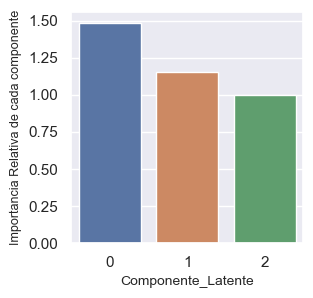

In [ ]:
sns.set(rc={'figure.figsize':(3,3)})
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma )
chart.set_xlabel('Componente_Latente', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada componente', fontdict={'size': 9})
plt.show()

In [ ]:
# La matriz V-transpuesta es la que genera la relación Terms(word)-Topics,
# los renglones son los términos/words y las columnas los tópicos/temas:

lsi_term_topic = V_T

print(lsi_term_topic.shape)

(14, 3)


In [ ]:
# rescatemos los nombres de los términos/tokens:

term_names = list(tfidf.get_feature_names_out())

print(term_names)

['autor', 'cocina', 'cuchara', 'estufa', 'ficcion', 'horno', 'libro', 'manzana', 'melon', 'novela', 'olla', 'pera', 'sandia', 'uva']


In [ ]:
# Y generamos un DataFrame con la matriz term-topic:

term_topic_matrix = pd.DataFrame(data=lsi_term_topic,
                                 index = term_names,
                                 columns = [f'Concepto_Latente_{r}' for r in range(0,V_T.shape[1])]
                                )

print(term_topic_matrix.shape)   #  words X topics

(14, 3)


Cada columna será un tópico (topic/Latent-Concept), donde se indican los pesos de cada palabra (term)
que define dicho tópico, a través de las palabras con los mayores pesos:

In [ ]:
#term_topic_matrix.head()    # Cuando es muy grande el DataFrame, mejor visualizarlo con head().

term_topic_matrix   # los renglones son los terms/words
                    # y las columnas los conceptos latentes o tópicos:

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2
autor,-1.561058e-17,-9.495402e-17,3.162278e-01
cocina,9.698820e-02,-1.328444e-01,3.465990e-16
cuchara,1.551490e-01,1.911549e-01,-1.975179e-15
estufa,1.472567e-01,4.349324e-01,1.735115e-15
ficcion,-1.561058e-17,-1.210803e-16,3.162278e-01
horno,3.311435e-01,4.570066e-01,-1.208919e-15
libro,-3.122116e-17,-2.421607e-16,6.324555e-01
manzana,4.833982e-01,-3.851308e-01,7.471785e-16
melon,2.656046e-01,-3.167591e-01,4.786493e-16
novela,-3.122116e-17,-2.421607e-16,6.324555e-01


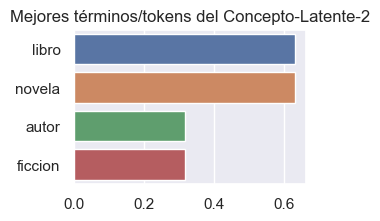

In [ ]:
# Seleccionemos por ejemplo una de las columnas/tópico "Concepto_Latente":

data = term_topic_matrix[f'Concepto_Latente_2']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.

top_w = 4      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)})
plt.title('Mejores términos/tokens del Concepto-Latente-2')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

Rápidamente observamos que el concepto latente asociado a estos terms sería en relación a un tema sobre autores de novelas, en paticular de ficción.

Puedes llevar a cabo la visualización de los Conceptos-Latentes restantes para determinar cuales podrían ser dichas temáticas.

Trata de determinar cómo podrías describir al resto de los tópicos, en relación a sus términos/words de mayor peso.

Podrías también hacerlo mediante nube de palabras.

Recuerda que no hay una solución única.

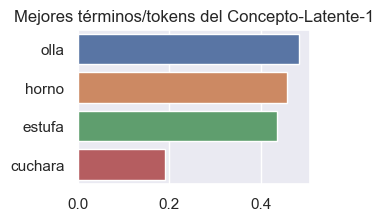

In [ ]:
# Otro de los conceptos latentes es el siguiente:

data = term_topic_matrix[f'Concepto_Latente_1']

# ordenamos lo valores singulares de la columna/tópico de manera descendente.
data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.

top_w = 4      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a
                               # los top_w terms (words).

sns.set(rc={'figure.figsize':(3,2)})
plt.title('Mejores términos/tokens del Concepto-Latente-1')
fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

¿Qué nombre le pondrías a esta temática?

Podrías además agregar una función que facilite la visualización de estos conceptos latentes.

# Parte - 2: LSI con Gensim


Obviamente existen funciones que implementan la SVD truncada de manera directa.

Estos métodos se basan en algoritmos iterativos que facilitan la obtención de dicha factorización, sobre todo con matrices de gran dimensión.

En esta actividad usaremos en particular la librería de Gensim.

Revisa la documentción correspondiente para mayor detalle y veamos lo que obtenemos.

Además, aprovecharemos para evaluar la cantidad de tópicos generados mediante la métrica de Coherencia. Recuerda que LSI es una técnica no supervisada y no conocemos de antemano la cantidad de tópicos en nuestro corpus.

https://radimrehurek.com/gensim/models/lsimodel.html

https://radimrehurek.com/gensim/models/coherencemodel.html

In [ ]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

En este caso partimos de la lista de listas con los documentos tokenizados:

In [ ]:
mi_dicc = corpora.Dictionary(docs)     # generamos el diccionario

bow = [mi_dicc.doc2bow(doc) for doc in docs]   # y luego la BOW

In [ ]:
for i in range(2,9):

    lsi = LsiModel(bow,
                   num_topics=i,
                   id2word=mi_dicc,
                   chunksize=6,
                   random_seed=7
                  )

    cm = CoherenceModel(model=lsi,
                        texts=docs,
                        dictionary=mi_dicc,
                        window_size=3,
                        coherence='c_v',
                        topn = 3
                       )

    cs = cm.get_coherence()

    print('Métrica de Coherencia con {} clusters: {}'.format(i, cs))

Métrica de Coherencia con 2 clusters: 0.2491406350758302
Métrica de Coherencia con 3 clusters: 0.25026891639723087
Métrica de Coherencia con 4 clusters: 0.24033388941780415
Métrica de Coherencia con 5 clusters: 0.23608410439864005
Métrica de Coherencia con 6 clusters: 0.24387557991244402
Métrica de Coherencia con 7 clusters: 0.25158729178298195
Métrica de Coherencia con 8 clusters: 0.32070071519773896


In [ ]:
# Seleccionas el mejor de los anteriores:

lsi = LsiModel(bow,
               num_topics=3,
               id2word=mi_dicc,
               chunksize=6,
               random_seed=7
               )

# Veamos la manera en que se distribuyen los términos en cada tópico generado:
for topic_num, words in lsi.print_topics(num_words=4):
    print('Tokens/Words in Topic {}: {}.'.format(topic_num, words))

Tokens/Words in Topic 0: 0.509*"horno" + 0.401*"estufa" + 0.396*"olla" + 0.386*"uva".
Tokens/Words in Topic 1: -0.468*"manzana" + 0.460*"estufa" + -0.406*"uva" + -0.374*"pera".
Tokens/Words in Topic 2: -0.507*"estufa" + 0.436*"pera" + -0.419*"manzana" + 0.329*"horno".


Sabemos que el corpus original podríamos clasificarlo en 3 tópicos.

En el caso de 3, podríamos a decir que alcanza distinguir a frutas de elementos sobre cocina pero no lo relacionado a novelas. Y en el caso de por ejemplo 7 tópicos, sabe distinguir bien el de temáticas de novelas, pero no alcanza a distiguir del todo las frutas y elementos de cocina.

La poca cantidad de documentos no permitió en este ejemplo mayor distinción, pero nos muestra la manera de proceder, en general.

# Parte - 3:

## Asignación de Dirichlet Latente - LDA - Latent Dirichlet Allocation

![image.png](attachment:image.png)

Matemáticamente dicho algoritmo LDA ilustrado arriba se puede escribir como sigue:

### $P(W,Z,θ,ϕ; α, β)= Π_{j=1}^{M} P(θ_{j}; α) Π_{t=1}^{K} P(ϕ_{t};β) \Pi_{i=1}^{N}P(Z_{j,i}|θ_{j})P(W_{j,i}|ϕ_{t}z_{j,i})$

Los dos hiperparámetros del método LDA que controlan la similaridad entre documentos, tópicos y palabras, son alfa y beta.

Mientras más palabras tengan los tópicos, mayor similaridad podrá existir entre ellos.

Así, mientras más pequeño es el alfa, “más enfocados” estarán los documentos en ciertos temas.

De manera análoga, mientras más pequeño es beta, “más enfocado” estará cada tópico. Es decir, cada tópico estará formado por el conjunto de palabras de todo el vobcabulario, donde a cada palabra le asigna una probabilidad. Cuando beta es pequeña, solo unas cuantas palabras tendrán una probabilidad grande, que serán las que definan el tópico en sí, y el resto tendrá valores muy cercanos a cero.

Observa que cada tópico no es entonces simplemente un conjunto de palabras, sino un conjunto de palabras con una función distribución de probabilidad.

En este ejemplo sencillo usaremos el modelo de Gensim llamado LdaModel, pero para documentos grandes conviene utilizar la opción paralelizable LdaMulticore:

https://radimrehurek.com/gensim/models/ldamodel.html

https://radimrehurek.com/gensim/models/ldamulticore.html

Continuemos en el corpus ya tokenizado y simplificado que definimos inicialmente:

In [ ]:
docs

[['manzana', 'manzana', 'pera', 'pera', 'uva', 'uva', 'melon', 'sandia'],
 ['manzana', 'manzana', 'manzana', 'uva', 'uva', 'melon', 'melon', 'cocina'],
 ['estufa', 'estufa', 'estufa', 'olla', 'olla', 'olla', 'horno', 'horno'],
 ['horno', 'horno', 'horno', 'cuchara', 'cuchara', 'olla', 'uva', 'uva'],
 ['horno', 'manzana', 'pera', 'pera', 'olla', 'olla'],
 ['libro', 'libro', 'autor', 'novela', 'novela', 'ficcion']]

In [ ]:
# generamos el diccionario:

id2word = corpora.Dictionary(docs)

for id in range(7):
    print(id2word[id])

manzana
melon
pera
sandia
uva
cocina
estufa


In [ ]:
# Generamos el corpus con las tuplas (índice, frecuencia):

corpus = [id2word.doc2bow(doc) for doc in docs]
corpus

[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 2)],
 [(0, 3), (1, 2), (4, 2), (5, 1)],
 [(6, 3), (7, 2), (8, 3)],
 [(4, 2), (7, 3), (8, 1), (9, 2)],
 [(0, 1), (2, 2), (7, 1), (8, 2)],
 [(10, 1), (11, 1), (12, 2), (13, 2)]]

In [ ]:
# Siempre podemos expresar cada documento con palabras para un mejor entendimiento:
[[(id2word[id], fre) for id, fre in cor] for cor in corpus[:2]]

[[('manzana', 2), ('melon', 1), ('pera', 2), ('sandia', 1), ('uva', 2)],
 [('manzana', 3), ('melon', 2), ('uva', 2), ('cocina', 1)]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=4,      # total de tópicos que deseas buscar...
                    chunksize=5,    # número de documentos a analizar en cada chunk de entrenamiento
                    passes=10,        # número de pasadas al corpus durante el entrenamiento.
                    alpha=0.2,        # alfa: similaridad document-topics
                    eta=0.2,         # beta: similaridad topic-words
                    )

In [ ]:
lda_model.print_topics(num_topics=4, num_words=4)

[(0, '0.206*"horno" + 0.206*"olla" + 0.141*"pera" + 0.110*"estufa"'),
 (1, '0.303*"novela" + 0.303*"libro" + 0.156*"autor" + 0.156*"ficcion"'),
 (2, '0.288*"manzana" + 0.217*"uva" + 0.185*"melon" + 0.077*"cocina"'),
 (3, '0.071*"sandia" + 0.071*"manzana" + 0.071*"ficcion" + 0.071*"autor"')]

En este caso sencillo, aunque sabemos que el número de tópicos son 3 estrictamente, con 4 tópicos es como se observan mejor las tres distribuciones tópicos-palabras. Es decir, sigue siendo requerida la inspección visual y criterio del analista para tomar la mejor decisión sobre la mejor cantidad de tópicos o conceptos latentes.

# Parte - 4: Predicción de datos nuevos

Una vez generado el modelo no supervisado LDA, supongamos que tenemos un nuevo documento del cual desramo saber a cuál tópico pertence. Veamos cómo proceder:

In [ ]:
dato_nuevo = ['uva', 'libro','autor','ficción']

In [ ]:
bow_nuevo

[(4, 1), (10, 1), (12, 1)]

In [ ]:
# Generamos su representación en lista de tuplas (idx,frec):
bow_nuevo = id2word.doc2bow(dato_nuevo)

# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in lda_model[bow_nuevo]]

# Contribucion de los topicos mas significativos
dist_contrib = [topico[1] for topico in lda_model[bow_nuevo]]

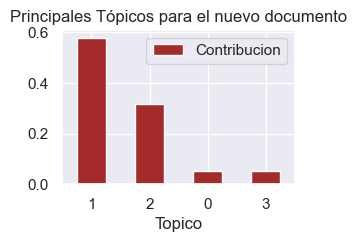

In [ ]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })

distribucion_topicos.sort_values('Contribucion',
                                 ascending=False, inplace=True)

ax = distribucion_topicos.plot.bar(y='Contribucion',
                                   x='Topico',
                                   rot=0,
                                   color="brown",
                                   title = 'Principales Tópicos para el nuevo documento')

In [ ]:
top_n = 4  # mostremos solo las primeras 4 de mayor similaridad semántica:

for ind, topico in distribucion_topicos.iterrows():
    print("<Tópico: " + str(int(topico.Topico)) + ">")
    palabras = [palabra[0] for k,palabra in
                enumerate(lda_model.show_topic(topicid=int(topico.Topico))) if k<top_n]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

<Tópico: 1>
novela, libro, autor, ficcion 

<Tópico: 2>
manzana, uva, melon, cocina 

<Tópico: 0>
horno, olla, pera, estufa 

<Tópico: 3>
sandia, manzana, autor, ficcion 



# Parte - 5: métrica de Coherencia

https://radimrehurek.com/gensim/models/coherencemodel.html

coherence: c_uci, c_v

window_size: c_uci:10, c_v:110

topn: solamente se extraen las topn palabras de cada tópico

Matemáticamente existen formas diferentes de definir la coherencia, aparte de que cada librería introduce en ocasiones diversas variantes.

Sin embargo, en general lo que trata de medir esta métrica en cada tópico es la similaridad semántica entre las palabras que pondera probabilísticamente.

Una de las formas usuales de definir esta métrica entre dos palabras $w_i$ y $w_j$ es de la forma siguiente:

$Coherencia_{UCI} = log{\frac{P(w_i,w_j)+1}{P(w_i)P(w_j)}}$

donde $P(w_i)$ es la probabilidad de ver dicha palabra en una ventana de longitud "window_size" y $P(w_i,w_j)$ es la probabilidad de que ambas palabras aparezcan en dicha ventana.

El valor entero "window_size" significa que la ventana de búsqueda se extiende a dicha cantidad de enteros, antes y después de una palabra central $w_i$.

Hay una definición más sencilla llamada usualmente $Coherencia_{UMASS}$ donde ahora considera la probabilidad de que aparezcan juntas dos palabras en un documento, con respecto a que una de ellas esté en dicho documento.

In [ ]:
# Veamos la evaluación con el valor de la coherencia:

coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=docs,
                                     dictionary=id2word,
                                     coherence='c_v',
                                     window_size=2,
                                     topn=5
                                     )

coherence_lda = coherence_model_lda.get_coherence()

print('Coherencia: ', coherence_lda)

Coherencia:  0.45489843250943296


In [ ]:
def valores_de_coherencia(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,      # total de tópicos que deseas buscar...
                    chunksize=6,    # número de documentos a analizar en cada chunk de entrenamiento
                    passes=10,        # número de pasadas al corpus durante el entrenamiento.
                    alpha=0.1,        # alfa: similaridad document-topics
                    eta=0.15,         # beta: similaridad topic-words
                    random_state=7
                    )


      model_list.append(model)


      coherencemodel = CoherenceModel(model=model,
                                      texts=texts,
                                      dictionary=dictionary,
                                      coherence='c_v',
                                      window_size=2,
                                      topn=3)

      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
start=2
limit=10
step=1

model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=docs,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

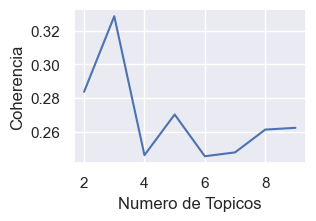

In [ ]:
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Numero de Topicos")
plt.ylabel("Coherencia")
plt.show()

In [ ]:
model_list[1].print_topics(num_words=4)

[(0, '0.153*"uva" + 0.153*"olla" + 0.153*"horno" + 0.153*"manzana"'),
 (1, '0.071*"horno" + 0.071*"manzana" + 0.071*"pera" + 0.071*"olla"'),
 (2, '0.265*"libro" + 0.265*"novela" + 0.142*"ficcion" + 0.142*"autor"')]

Como comentamos previamente, en ocasiones la métrica de coherencia nos lleva al teóricamente cantidad de tópicos correctos, pero no a la mejor distribución de las palabras en cada tópico.

# Parte - 6: BIGRAMAS y TRIGRAMAS

Recordemos que un "n-grama" es una cadena de "n" caracteres cuya frecuencia es suficientemente alta, como para empezar a considerarlo como un solo token.

En particular, nombres de personas, instituciones, ciudades o productos son ejemplos típicos de "n-gramas".

Los "n-gramas" enriquecen en gran medida el sisgnificado de los documentos, ya que la secuencia de dichos tokens tienen un significado muy diferente al que tiene cada uno de ellos por separado.

Cuando sabemos de antemano que estamos trabajando con ciertos "n-gramas", se pueden incluir desde un inicio como tales. Por ejemplo, Tecnológico de Monterrey, podría considerarse como un tri-grama y sustituir este conjunto de palabras por Tecnologico_de_Monterrey, o bien TecnologicoDeMonterrey, entre otras formas diferentes que pudieran considerarse.

En dado caso, si se incluyen guiones bajos como en este ejemplo para definir un "n-grama", deberás tomarlo en cuenta para que no se pierdan durante el proceso de limpieza.

In [ ]:
from gensim.models import Phrases

In [ ]:
texto = [['Octavio Paz, fue un poeta, ensayista y diplomático mexicano.'],
         ['Octavio Paz obtuvo el Premio Nobel de Literatura en 1990 y el Premio Cervantes en 1981.'],
         ['Se le considera uno de los más influyentes autores del siglo xx y uno de los más grandes poetas de todos los tiempos.'],
         ['Su padre fue Octavio Paz Solórzano y su madre Josefina Lozano.'],
         ['Octavio Paz nació en la Ciudad de México el 31 de marzo de 1914.'],
         ['Murió en la Ciudad de México el 19 de abril de 1998.'],
         ['De pequeño vivió con su abuelo en Mixcoac, en ese entonces un poblado cercano a la Ciudad de México.']
        ]

txt_token = [txt[0].split(' ') for txt in texto]


print(txt_token[0:2])

[['Octavio', 'Paz,', 'fue', 'un', 'poeta,', 'ensayista', 'y', 'diplomático', 'mexicano.'], ['Octavio', 'Paz', 'obtuvo', 'el', 'Premio', 'Nobel', 'de', 'Literatura', 'en', '1990', 'y', 'el', 'Premio', 'Cervantes', 'en', '1981.']]


In [ ]:
# Búsqueda de bigramas:

bigramas = gensim.models.phrases.Phrases(txt_token, min_count=2, threshold=10)

for bb in bigramas[txt_token]:
    print(bb)

['Octavio', 'Paz,', 'fue', 'un', 'poeta,', 'ensayista', 'y', 'diplomático', 'mexicano.']
['Octavio_Paz', 'obtuvo', 'el', 'Premio', 'Nobel', 'de', 'Literatura', 'en', '1990', 'y', 'el', 'Premio', 'Cervantes', 'en', '1981.']
['Se', 'le', 'considera', 'uno', 'de', 'los', 'más', 'influyentes', 'autores', 'del', 'siglo', 'xx', 'y', 'uno', 'de', 'los', 'más', 'grandes', 'poetas', 'de', 'todos', 'los', 'tiempos.']
['Su', 'padre', 'fue', 'Octavio_Paz', 'Solórzano', 'y', 'su', 'madre', 'Josefina', 'Lozano.']
['Octavio_Paz', 'nació', 'en', 'la_Ciudad', 'de', 'México', 'el', '31', 'de', 'marzo', 'de', '1914.']
['Murió', 'en', 'la_Ciudad', 'de', 'México', 'el', '19', 'de', 'abril', 'de', '1998.']
['De', 'pequeño', 'vivió', 'con', 'su', 'abuelo', 'en', 'Mixcoac,', 'en', 'ese', 'entonces', 'un', 'poblado', 'cercano', 'a', 'la_Ciudad', 'de', 'México.']


In [ ]:
# Búsqueda de Trigramas como la búsqueda de bigramas dentro de un corpus que ya incluye bigramas:

for k in range(len(txt_token)):
    print(trigramas[bigramas[txt_token[k]]])

['Octavio', 'Paz,', 'fue', 'un', 'poeta,', 'ensayista', 'y', 'diplomático', 'mexicano.']
['Octavio_Paz', 'obtuvo', 'el', 'Premio', 'Nobel', 'de', 'Literatura', 'en', '1990', 'y', 'el', 'Premio', 'Cervantes', 'en', '1981.']
['Se', 'le', 'considera', 'uno', 'de', 'los', 'más', 'influyentes', 'autores', 'del', 'siglo', 'xx', 'y', 'uno', 'de', 'los', 'más', 'grandes', 'poetas', 'de', 'todos', 'los', 'tiempos.']
['Su', 'padre', 'fue', 'Octavio_Paz', 'Solórzano', 'y', 'su', 'madre', 'Josefina', 'Lozano.']
['Octavio_Paz', 'nació', 'en', 'la_Ciudad_de', 'México', 'el', '31', 'de', 'marzo', 'de', '1914.']
['Murió', 'en', 'la_Ciudad_de', 'México', 'el', '19', 'de', 'abril', 'de', '1998.']
['De', 'pequeño', 'vivió', 'con', 'su', 'abuelo', 'en', 'Mixcoac,', 'en', 'ese', 'entonces', 'un', 'poblado', 'cercano', 'a', 'la_Ciudad_de', 'México.']


De esta manera se podría continuar la búsqueda de tetra-gramas y mayores, pero generalmente es incluirlos de manera directa con base al conocimiento de tus documentos, como se mención previamente.

La cantidad de "n-gramas" va disminuyendo a medida que se incrementa el valor de "n".

## Fin de los ejercicios complementarios de las semanas 6 y 7.